In [24]:
import pandas as pd
import numpy as np
from pyarrow import Table
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from source import *
from pathlib import Path

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import scienceplots

plt.style.use(['science','ieee', 'grid'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [25]:
vars = ['cmpmiss', 'recM2_Ups', 'ang_taus', 'asymmetry', "ang_tau0_pmiss", "ang_tau1_pmiss", 
        "p_tau_0", "p_tau_1", "theta_Btag", "cmthetamiss", 'tau_d_0_0', 'tau_d_1_0', "N_KL"]

In [26]:
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012) & (pc.field("N_KS") < 0.5)
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")

In [27]:
sig = ds.dataset(list(Path(f"new_sig/").glob("*.parquet")), format="parquet")
sig = get_values(sig, vars, filter_mask=mask & mask_lep & mask_is1 & (pc.field("is0") == 1))
lep = ds.dataset(list(Path(f"halfleptonic/").glob("*.parquet")), format="parquet")
lep = get_values(lep, vars, filter_mask=mask & mask_lep & (pc.field("is0") == 1))

Total data size: 6.53 MB
Total data size: 2.88 MB


In [28]:
lep["label"] = 0  # Класс 0
sig["label"] = 1  # Класс 1
df = pd.concat([sig, lep], ignore_index=True)

In [29]:
X = df.drop(columns=["label"])
y = df["label"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [31]:
def gini_eval(preds, dtrain):
    labels = dtrain.get_label()
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(labels, preds)
    gini = 2 * auc - 1
    return 'gini', gini

In [32]:

w_train = np.where(y_train == 0, 1.0, len(lep) / len(sig))

model = XGBClassifier(
    max_depth=8,
    n_estimators=5000,
    learning_rate=0.01,
    subsample=0.5,
    colsample_bytree=1,
    random_state=42,
)
model.fit(X_train, y_train, sample_weight=w_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [33]:

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.45      0.46     10097
           1       0.76      0.77      0.77     22923

    accuracy                           0.67     33020
   macro avg       0.61      0.61      0.61     33020
weighted avg       0.67      0.67      0.67     33020

ROC AUC: 0.6571561550296677
Confusion Matrix:
 [[ 4537  5560]
 [ 5253 17670]]


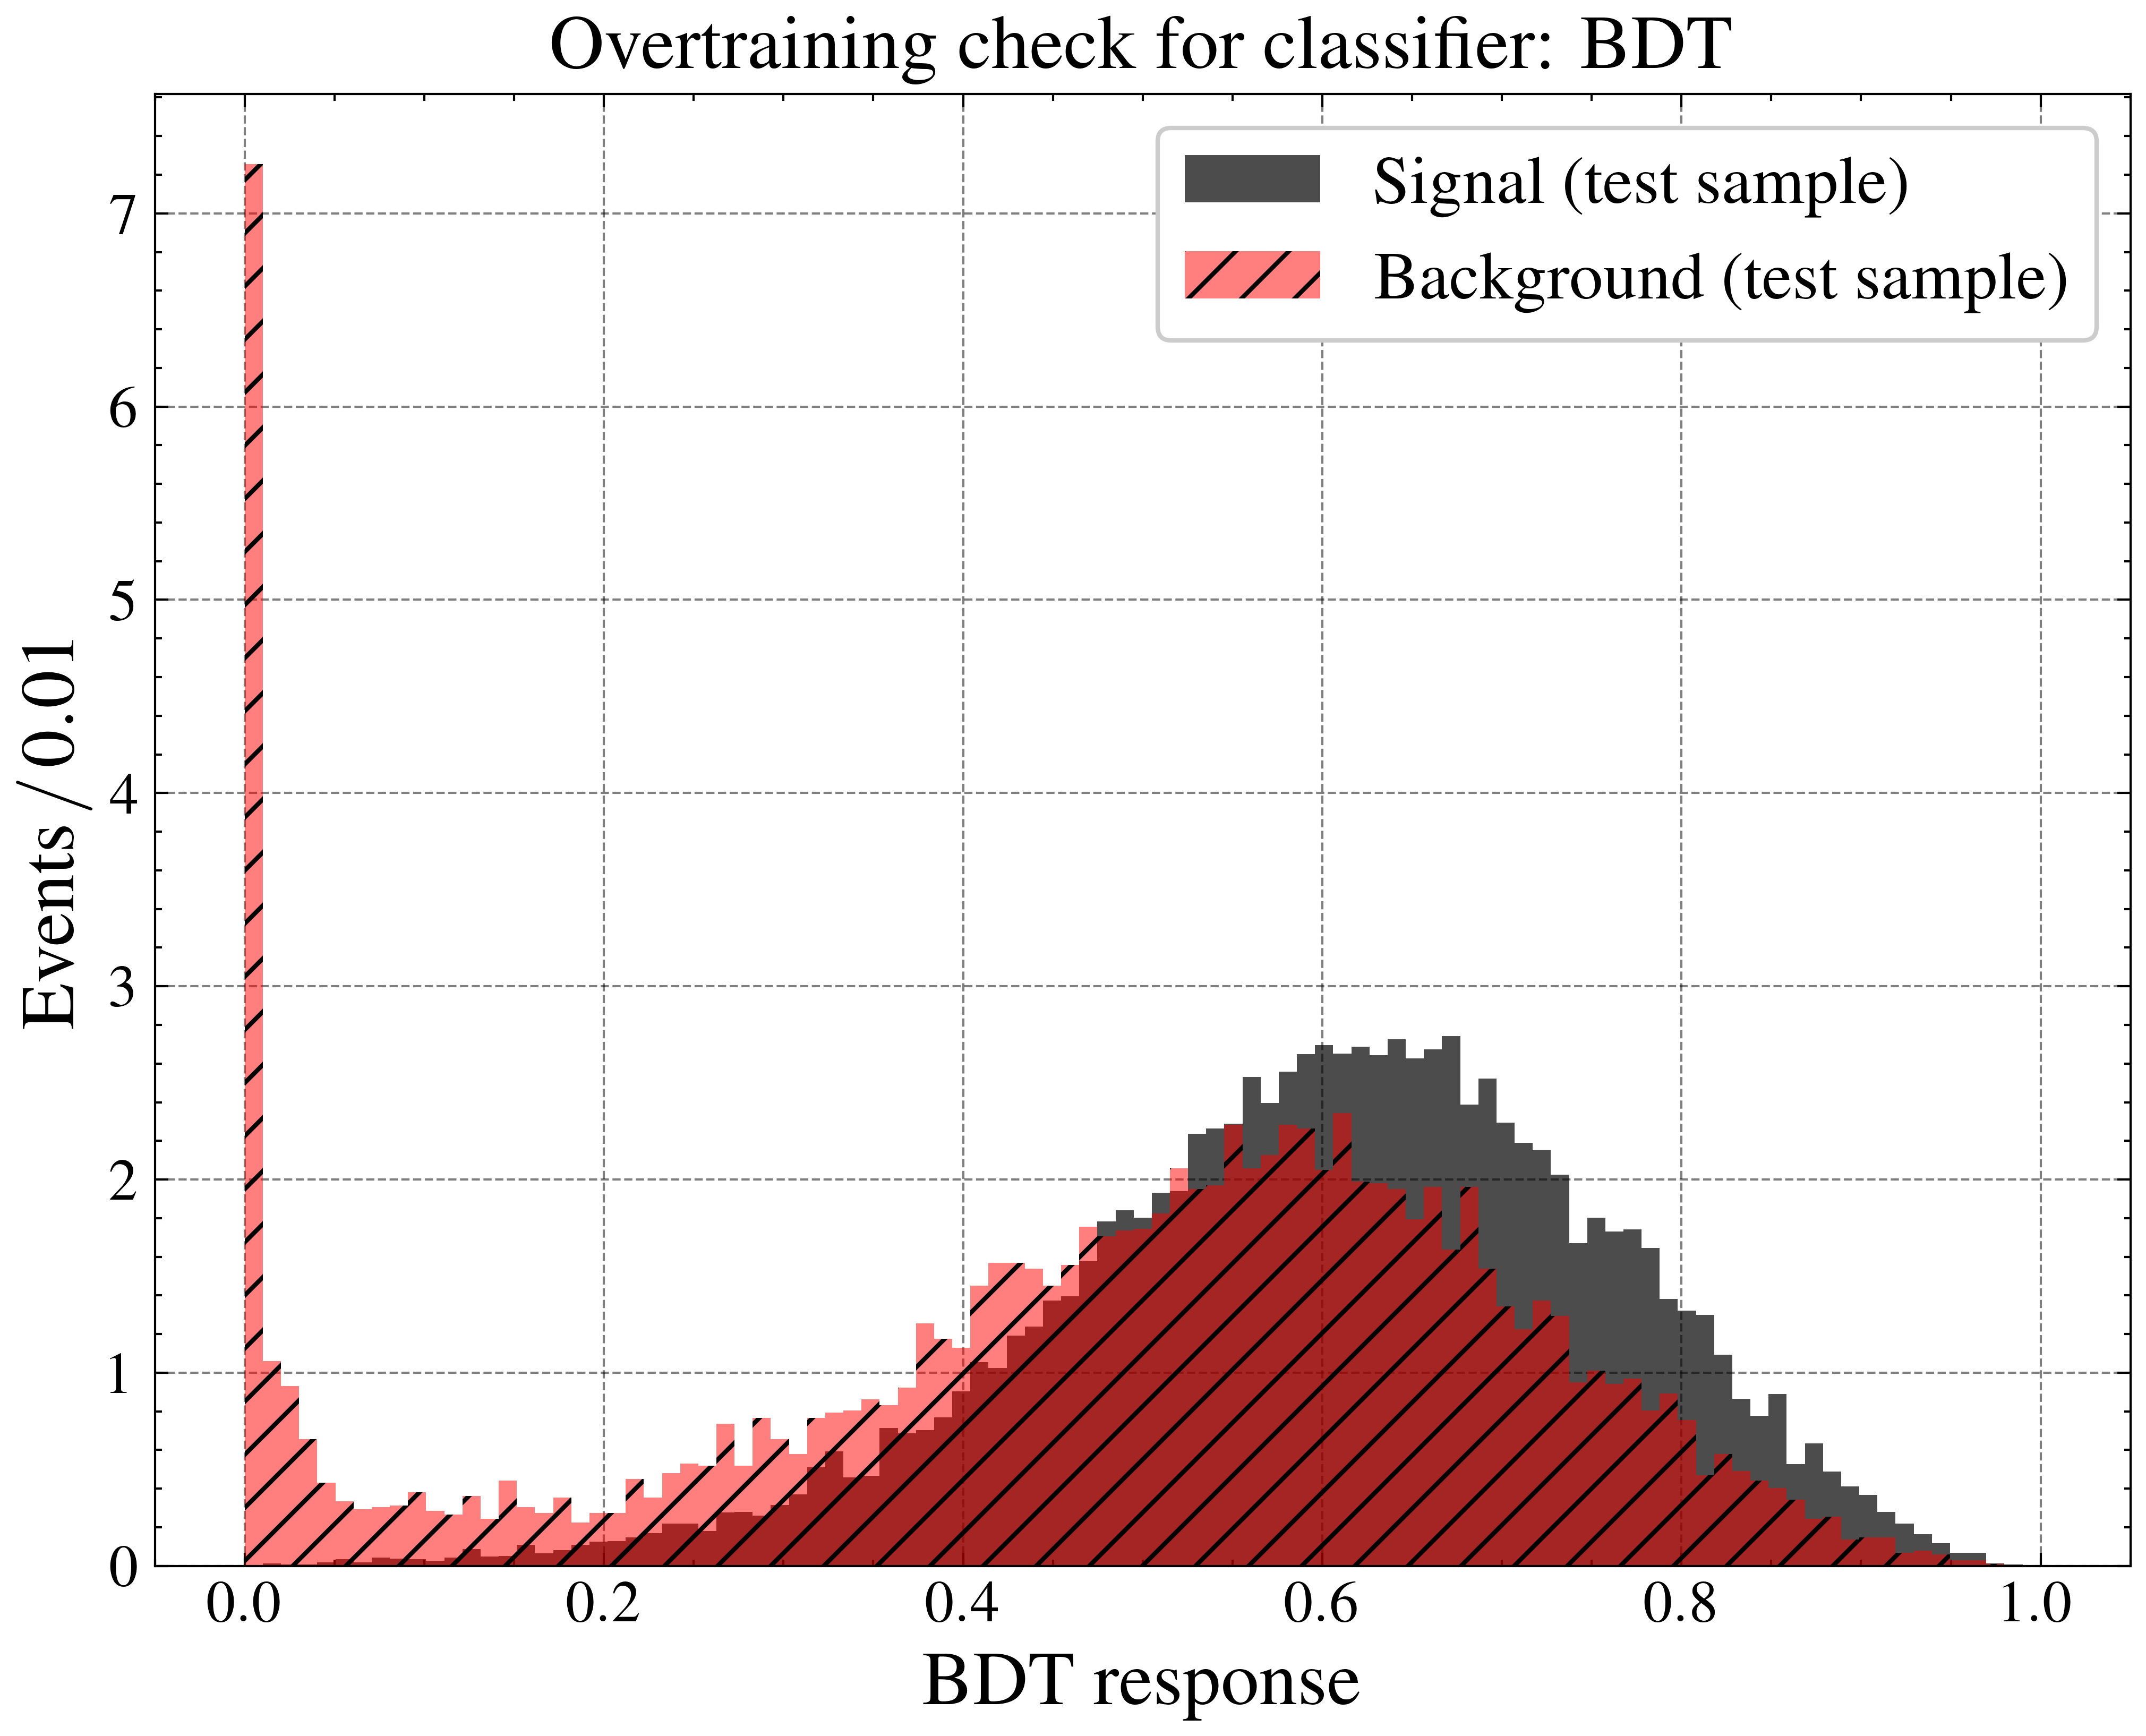

In [34]:
wbin = 0.01
a = 0
b = 1
bins = np.linspace(a, b, int((b-a)/wbin))


train_pred = model.predict_proba(X_train)[:, 1]
test_pred = model.predict_proba(X_test)[:, 1]

# Выбираем маски
sig_train = train_pred[y_train == 1]
bkg_train = train_pred[y_train == 0]
sig_test = test_pred[y_test == 1]
bkg_test = test_pred[y_test == 0]

# === График ===
plt.figure(figsize=(8, 6))


# Гистограммы
plt.hist(sig_test, bins=bins, density=True, alpha=0.7, label="Signal (test sample)")
plt.hist(bkg_test, bins=bins, density=True, alpha=0.5, label="Background (test sample)", hatch="//")


# === Подписи ===
plt.xlabel("BDT response")
plt.ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}$')
plt.title("Overtraining check for classifier: BDT")
plt.legend(loc='best')
plt.savefig("output/BDT_output.pdf", dpi=700)


In [35]:
import xgboost as xgb

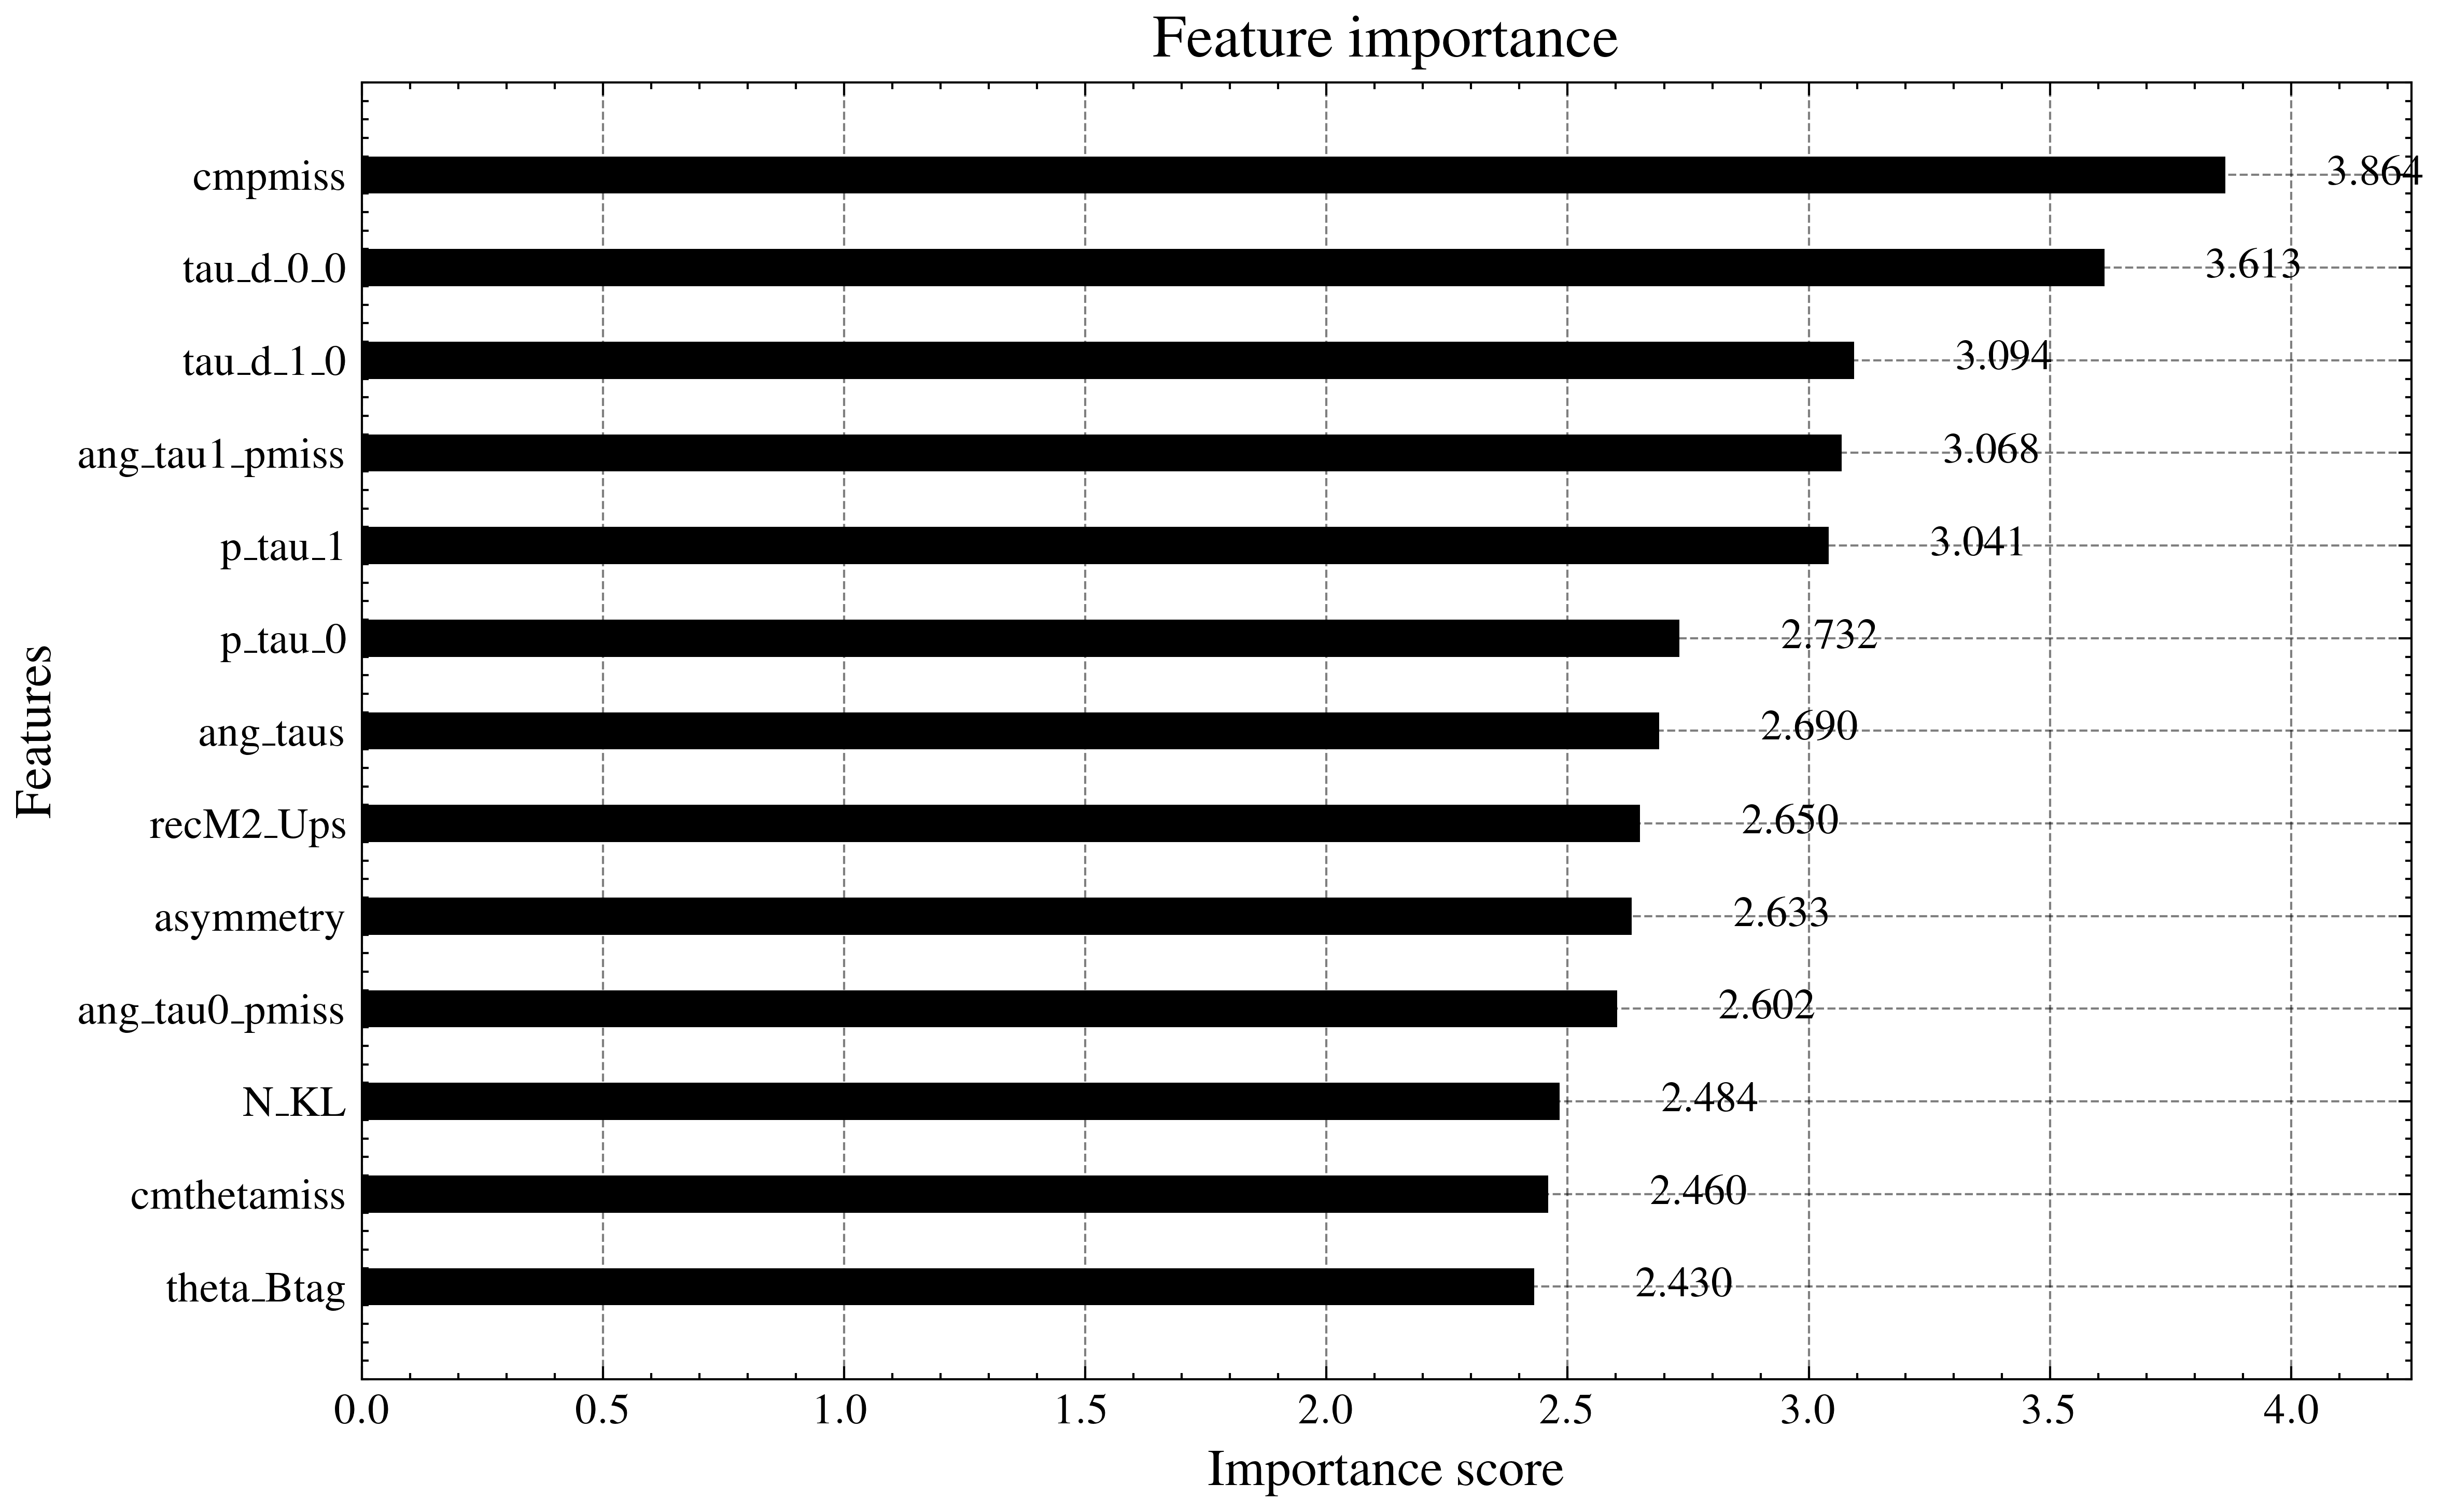

In [36]:
fig, ax = plt.subplots(figsize=(8, 5)) 

xgb.plot_importance(
    model,
    ax=ax,
    importance_type='gain',
    max_num_features=15,
    height=0.4,
    show_values=False, 
    grid=True
)

for rect in ax.patches:
    width = rect.get_width()
    y = rect.get_y() + rect.get_height() / 2
    ax.text(
        width + 0.05 * ax.get_xlim()[1],  
        y,
        f"{width:.3f}",
        va='center',
        ha='left',
        fontsize=10
    )

ax.set_title("Feature importance", fontsize=14)
ax.set_xlabel("Importance score", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.savefig("output/BDT_features.pdf", dpi=700)
plt.show()

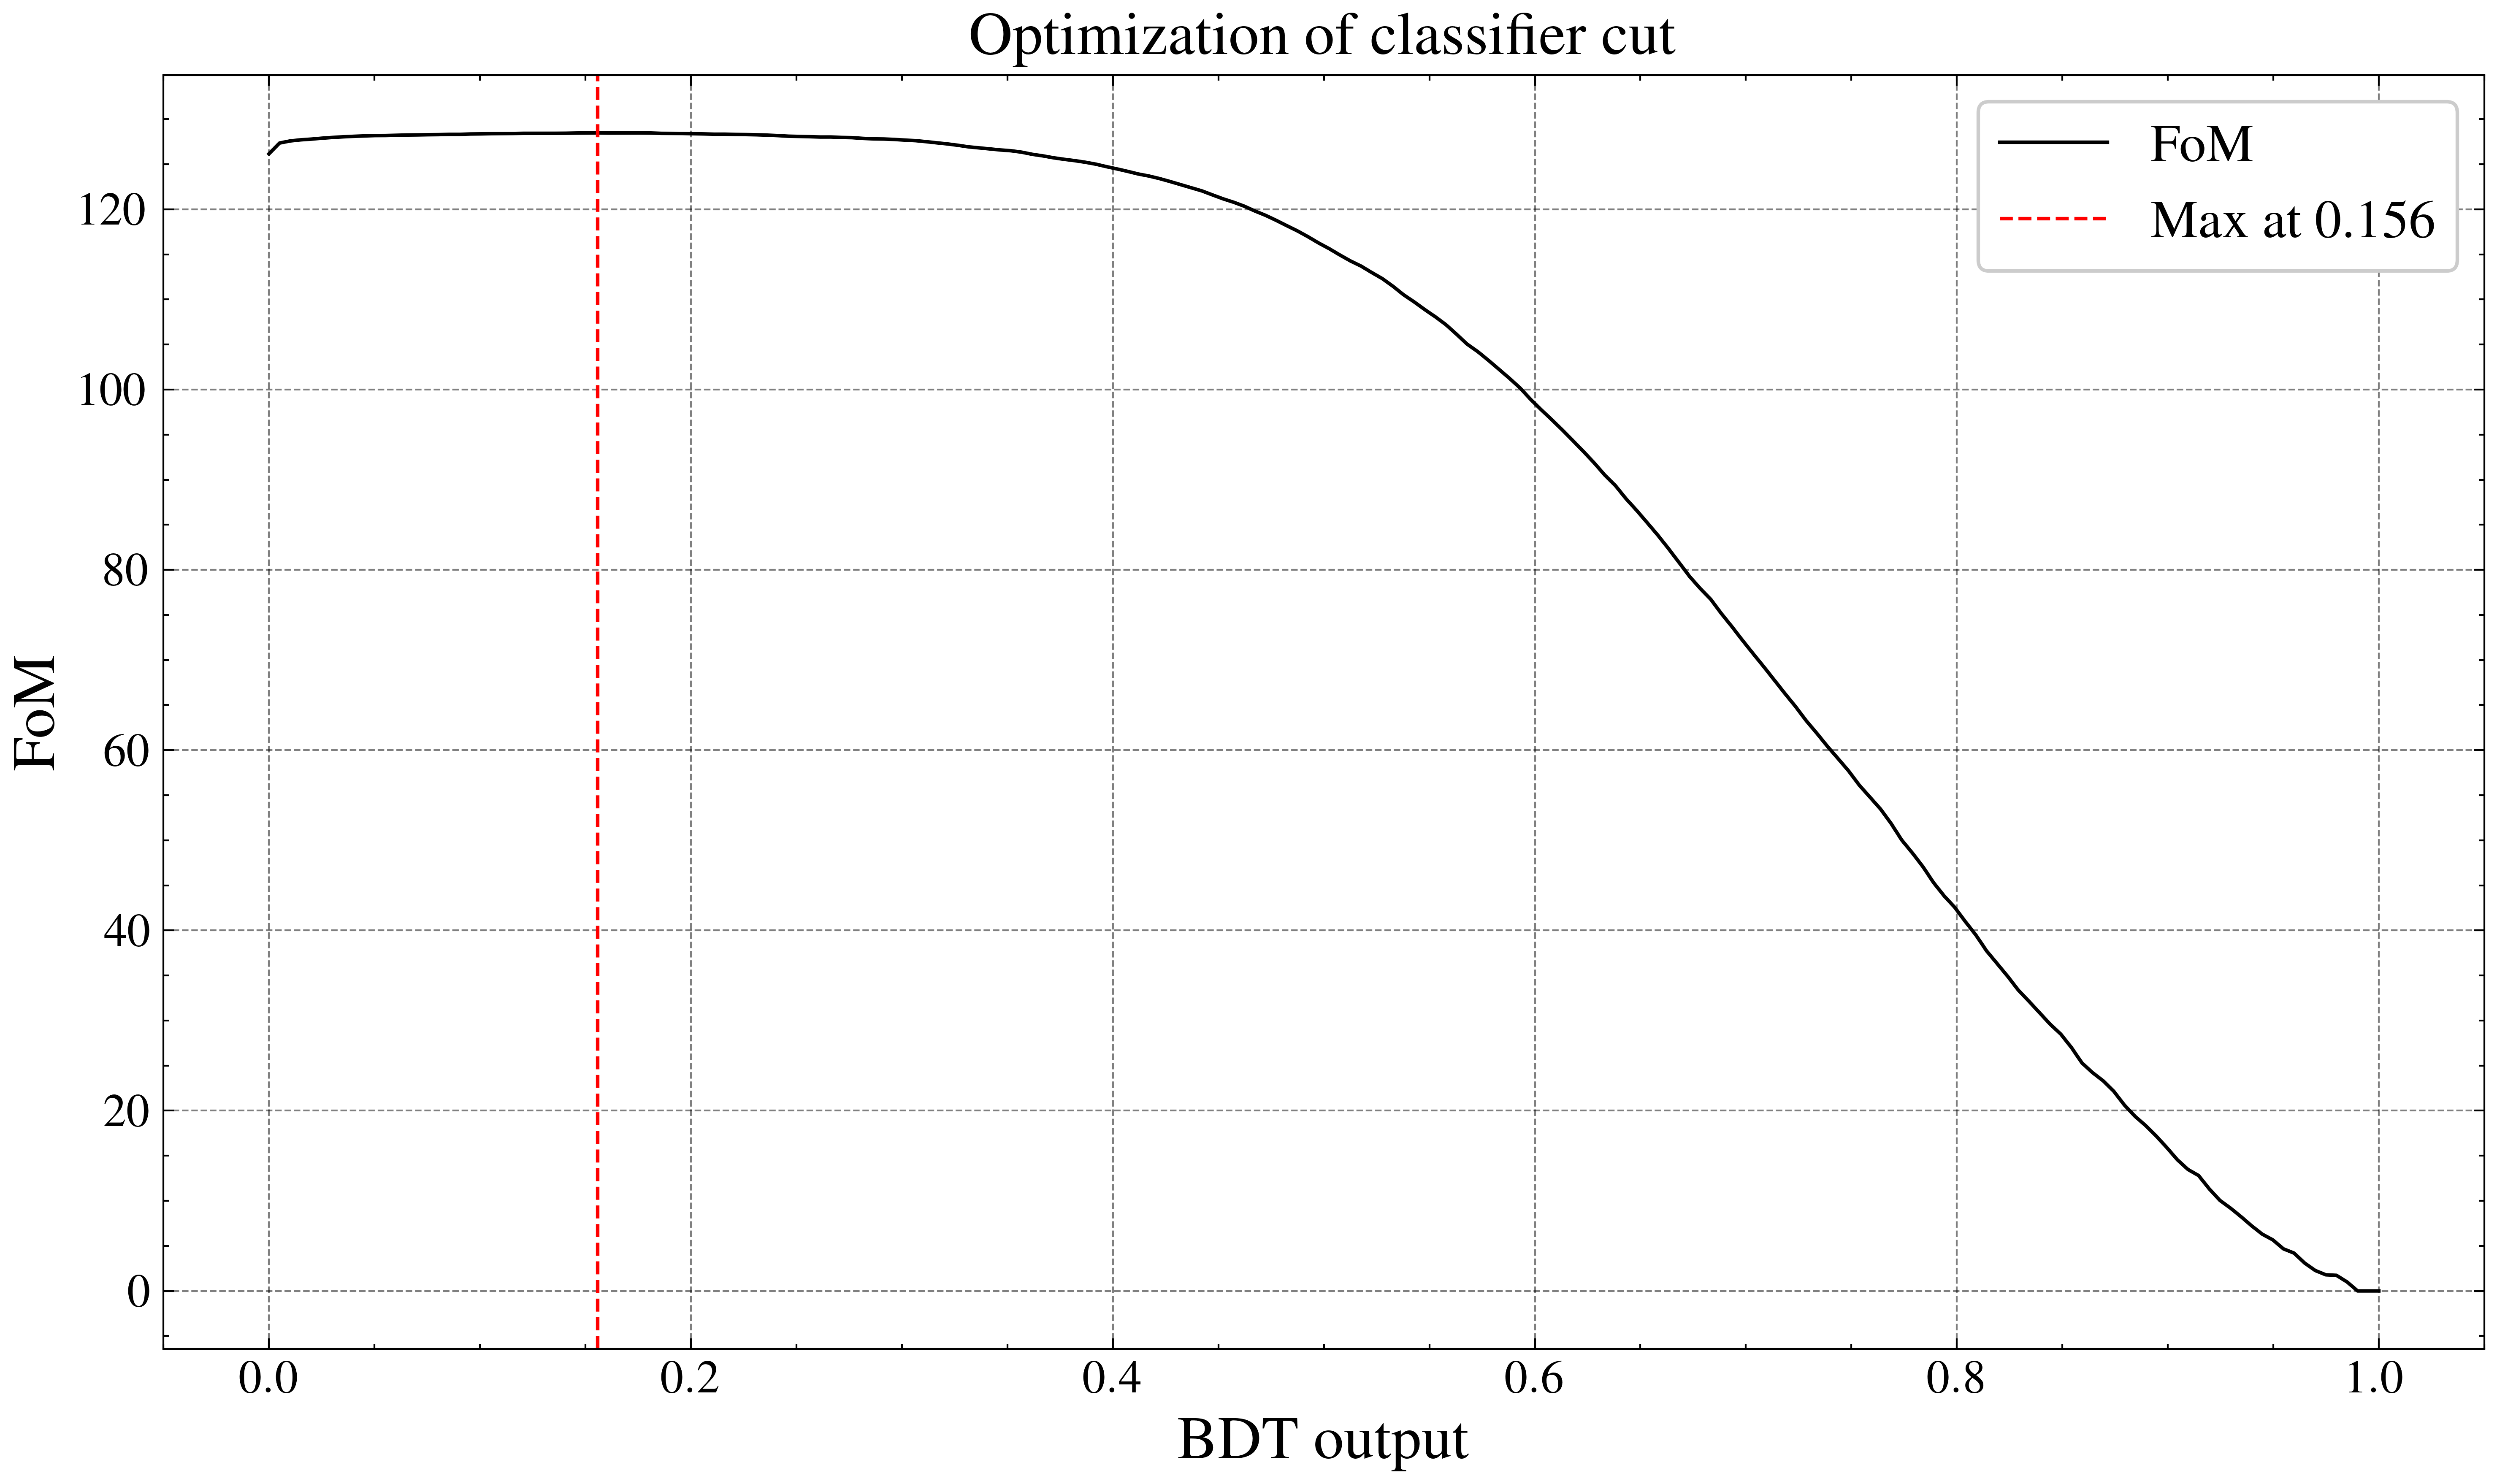

Best BDT cut: 0.156, Max FoM = 128.479


In [37]:
# Тестовые вероятности и истинные метки
preds = test_pred
true = y_test.to_numpy()

# Маски для сигналов и фонов
is_sig = true == 1
is_bkg = true == 0

# Количество событий всего
Nsig_tot = np.sum(is_sig)
Nbkg_tot = np.sum(is_bkg)

# Веса если есть
weight_sig = np.ones_like(preds[is_sig])
weight_bkg = np.ones_like(preds[is_bkg])

# Тестовые пороги
cuts = np.linspace(0, 1, 200)

FoM = []
effS = []
effB = []

for cut in cuts:
    # Считаем, сколько сигналов и фонов выше порога
    S = np.sum(weight_sig[preds[is_sig] > cut])
    B = np.sum(weight_bkg[preds[is_bkg] > cut])
    
    fom = S / np.sqrt(S + B + 1e-6)  # добавляем малое число для стабильности
    FoM.append(fom)
    effS.append(S / Nsig_tot)
    effB.append(B / Nbkg_tot)

# Переводим в numpy для удобства
FoM = np.array(FoM)
effS = np.array(effS)
effB = np.array(effB)

# Находим максимум
imax = np.argmax(FoM)
best_cut = cuts[imax]

# === Рисуем ===
plt.figure(figsize=(10, 6))
plt.plot(cuts, FoM, label='FoM')
plt.axvline(best_cut, color='r', linestyle='--', label=f'Max at {best_cut:.3f}')
plt.xlabel("BDT output")
plt.ylabel("FoM")
plt.title("Optimization of classifier cut")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/BDT_FoM.pdf", dpi=700)
plt.show()

print(f"Best BDT cut: {best_cut:.3f}, Max FoM = {FoM[imax]:.3f}")


In [38]:
model.save_model("output/bdt_model.json")

In [39]:
list(lep.columns)

['cmpmiss',
 'recM2_Ups',
 'ang_taus',
 'asymmetry',
 'ang_tau0_pmiss',
 'ang_tau1_pmiss',
 'p_tau_0',
 'p_tau_1',
 'theta_Btag',
 'cmthetamiss',
 'tau_d_0_0',
 'tau_d_1_0',
 'N_KL',
 'label']

In [40]:
list(lep.columns).remove

<function list.remove(value, /)>

In [41]:
import json

# Сохраняем имена колонок и значения FoM в json
data_to_save = {
    "columns": list(lep.columns)[:-1],
    "FoM": float(best_cut)
}

with open("output/columns_and_fom.json", "w") as f:
    json.dump(data_to_save, f, indent=4)

In [42]:
from xgboost import XGBClassifier
import json
model = XGBClassifier()
model.load_model("output/bdt_model.json")
with open("output/columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [5]:
a = [0.05115646258503402,
0.12462585034013608,
0.0653061224489796,
0.008571428571428574,
0.03333333333333334,
0.0163265306122449,
0.0008163265306122449,
0.05578231292517008,
0.043537414965986405,
0.06122448979591837,
0.009931972789115649,
0.11428571428571431,
0.0006802721088435376,
0.043537414965986405,
0.0025850340136054427,
0.03292517006802721,
0.003537414965986395,
0.0979591836734694,
0.029387755102040822,
0.06122448979591837,
0.07346938775510205,
0.0036734693877551027,
0.0006802721088435376,
0.0028571428571428576,
0.008027210884353743,
0.0031292517006802725,
0.014285714285714289,
0.030068027210884363,
0.002448979591836735]

In [6]:
sum(a)

0.9953741496598641